# Preprocessing: BJH025


This markdown files loads the clean data and does a bipolar rereference as well as epochs the data.

This subject tried to use pausing creatively to get out of dying, which messed with some of the triggers. It took some sleuthing, but I was able to recover the true ending/begining times by comparing the behavioral data with the STI channel.

Here is a record of the changes, which the trial notation begining at 1, as it does in the behavioral files:

* Trial 5 ends at sample 72226, around 36 seconds into the game
* Trial 6 begins at sample 87300, 43 seconds into the game
* Trial 6 ends at 107622, 53 seconds into the game
* During one death, the patient tried to pause to avoid the sounds. That triggered a false end of trial event at 508000 (254 seconds), which I removed.
* Trial ten was paused in the middle for about 20 seconds


In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns

In [8]:
%matplotlib qt5

In [2]:
## Prep paths ##

subject = 'BJH025'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [19]:
## Load Data ##

# load filtered data #
filtered_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif")

# load raw data #
raw_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif")



Opening raw data file /home/brooke/pacman/raw_data/BJH025/ieeg/BJH025_notched_filtered_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH025/ieeg/BJH025_notched_filtered_clean_ieeg-1.fif...
    Range : 2086000 ... 2966399 =   1043.000 ...  1483.199 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH025/ieeg/BJH025_raw_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH025/ieeg/BJH025_raw_clean_ieeg-1.fif...
    Range : 2086000 ... 2966399 =   1043.000 ...  1483.199 secs
Ready.


## Bipolar Rereferencing

In [20]:
# helper functions

def probe_and_num(elec_str): 
    ''' This convenience function takes an electrode string like LHH1 and outputs ('LHH', 1)
    '''
    if '_' in elec_str:
        return None, None
    else:   
        regex_str = '(\D+)(\d+)' # group of letters followed by group of digits
        matcher = re.compile(regex_str,re.IGNORECASE|re.DOTALL).search(elec_str)
        if matcher:
            probe, num = matcher.groups()
            return probe, int(num)
        else:
            return None, None
    
def find_bipolar_pair(ch, labels, remove):
    ''' Find the pair of a given electrode for bipolar referencing.
        Given a single *ch* and a list of *labels*, some of which you want to *remove*,
        this finds the next channel on that probe that isn't meant to be removed (WM is ok).
    '''
    bipolar_pair = None
    probe, num = probe_and_num(ch)
    other_in_probe = [other_ch for other_ch in labels if probe_and_num(other_ch)[0]==probe]
    for i in range(len(other_in_probe)-num):
        next_ch = probe + str(num+i+1)
        if next_ch in remove or next_ch == 'STI':
            continue
        else:
            bipolar_pair = next_ch
            break
    return bipolar_pair

In [21]:
# Here I iterate through the electrodes in my ROIs and match them up with their bipolar pair
pairs = []
anode = []
cathode = []
pairs_name = []
pairs_map = {}
remove = filtered_clean_fif.info['bads']
labels = filtered_clean_fif.info['ch_names']
for ch in labels:
    # if a channel is meant to be removed, it doesn't get to be in a bipolar pair
    if ch in remove or ch == 'STI':
        print(f"{ch} noref")
    else:
        pair = find_bipolar_pair(ch, labels, remove)
        if pair:
            anode.append(ch)
            cathode.append(pair)
            pairs.append((ch, pair))
            pairs_map[ch] = f"{ch}-{pair}"
            pairs_name.append(f"{ch}-{pair}")
            print(ch, pair)

EMPTY noref
EMPTY_2 noref
EMPTY_3 noref
EMPTY_4 noref
REF1 noref
REF2 noref
A1 A2
A2 A3
A3 A4
A4 A5
A5 A6
A6 A7
A7 A8
A8 A9
A9 A10
A10 A11
A11 A12
A12 A13
A13 A14
A14 A15
A15 A16
B1 B2
B2 B3
B3 B4
B4 B5
B5 B6
B6 B7
B7 B8
B8 B9
B9 B10
B10 B11
B11 B12
B12 B13
B13 B14
B14 B15
B15 B16
C1 C2
C2 C3
C3 C4
C4 C5
C5 C6
C6 C7
C7 C8
C8 C9
C9 C10
C10 C11
C11 C12
C12 C13
C13 C14
C14 C15
C15 C16
D1 D2
D2 D3
D3 D4
D4 D5
D5 D6
D6 D7
D7 D9
D8 noref
D9 D10
E1 E2
E2 E3
E3 E4
E4 E5
E5 E6
E6 E7
E7 E8
E8 E9
E9 E10
E10 E11
E11 E12
F1 F2
F2 F3
F3 F4
F4 F5
F5 F6
F6 F7
F7 F8
GR1 GR2
GR2 GR3
GR3 GR4
GR4 GR5
GR5 GR6
GR6 GR7
GR7 GR8
GR8 GR9
GR9 GR10
GR10 GR11
GR11 GR12
GR12 GR13
GR13 GR14
GL1 GL2
GL2 GL3
GL3 GL4
GL4 GL5
GL5 GL6
GL6 GL7
GL7 GL8
GL8 GL9
GL9 GL10
GL10 GL11
GL11 GL12
HR1 noref
HR2 HR3
HR3 HR4
HR4 HR5
HR5 HR6
HR6 HR7
HR7 HR8
HL1 noref
HL2 HL3
HL3 HL4
HL4 HL5
HL5 HL6
HL6 HL7
HL7 HL8
I1 I2
I2 I3
I3 I4
I4 I5
I5 I6
I6 I7
I7 I8
I8 I9
I9 I10
I10 I11
I11 I12
J1 J2
J2 J3
J3 J4
J4 J5
J5 J6
J6 J7
J7 J8
J8 J9
J9 

In [22]:
## Apply Rereference #

if filtered_clean_fif.info['ch_names'] == raw_clean_fif.info['ch_names'] and filtered_clean_fif.info['bads'] == raw_clean_fif.info['bads']:
    
    # load filtered data
    filtered_clean_fif.load_data()
    
    # set filtered reference 
    bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)
    
    # clear var
    bp_filt_fif = []
    filtered_clean_fif = []
    
    # load raw data
    raw_clean_fif.load_data()
    
    # set raw reference 
    bp_raw_fif = mne.set_bipolar_reference(raw_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)

    
    # clear var
    bp_raw_fif = []
    raw_clean_fif = []    
    
    

Reading 0 ... 2966399  =      0.000 ...  1483.199 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=153, n_times=2966400
    Range : 0 ... 2966399 =      0.000 ...  1483.199 secs
Ready.
Added the following bipolar channels:
A1-A2, A2-A3, A3-A4, A4-A5, A5-A6, A6-A7, A7-A8, A8-A9, A9-A10, A10-A11, A11-A12, A12-A13, A13-A14, A14-A15, A15-A16, B1-B2, B2-B3, B3-B4, B4-B5, B5-B6, B6-B7, B7-B8, B8-B9, B9-B10, B10-B11, B11-B12, B12-B13, B13-B14, B14-B15, B15-B16, C1-C2, C2-C3, C3-C4, C4-C5, C5-C6, C6-C7, C7-C8, C8-C9, C9-C10, C10-C11, C11-C12, C12-C13, C13-C14, C14-C15, C15-C16, D1-D2, D2-D3, D3-D4, D4-D5, D5-D6, D6-D7, D7-D9, D9-D10, E1-E2, E2-E3, E3-E4, E4-E5, E5-E6, E6-E7, E7-E8, E8-E9, E9-E10, E10-E11, E11-E12, F1-F2, F2-F3, F3-F4, F4-F5, F5-F6, F6-F7, F7-F8, GR1-GR2, GR2-GR3, GR3-GR4, GR4-GR5, GR5-GR6, GR6-GR7, GR7-GR8, GR8-GR9, GR9-GR10, GR10-GR11, GR11-GR12, GR12-GR13, GR13-GR14, GL1-GL2, GL2-GL3, GL3-GL4, GL4-GL5, GL5-GL6, GL6-GL7, GL

/tmp/ipykernel_95479/1336304392.py:12: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif
[done]
Reading 0 ... 2966399  =      0.000 ...  1483.199 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=153, n_times=2966400
    Range : 0 ... 2966399 =      0.000 ...  1483.199 secs
Ready.
Added the following bipolar channels:
A1-A2, A2-A3, A3-A4, A4-A5, A5-A6, A6-A7, A7-A8, A8-A9, A9-A10, A10-A11, A11-A12, A12-A13, A13-A14, A14-A15, A15-A16, B1-B2, B2-B3, B3-B4, B4-B5, B5-B6, B6-B7, B7-B8, B8-B9, B9-B10, B10-B11, B11-B12, B12-B13, B13-B14, B14-B15, B15-B16, C1-C2, C2-C3, C3-C4, C4-C5, C5-C6, C6-C7, C7-C8, C8-C9, C9-C10, C10-C11, C11-C12, C12-C13, C13-C14, C14-C15, C15-C16, D1-D2, D2-D3, D3-D4, D4-D5, D5-D6, D6-D7, D7-D9, D9-D10, E1-E2, E2-E

/tmp/ipykernel_95479/1336304392.py:25: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data.fif
[done]


Opening raw-browser...


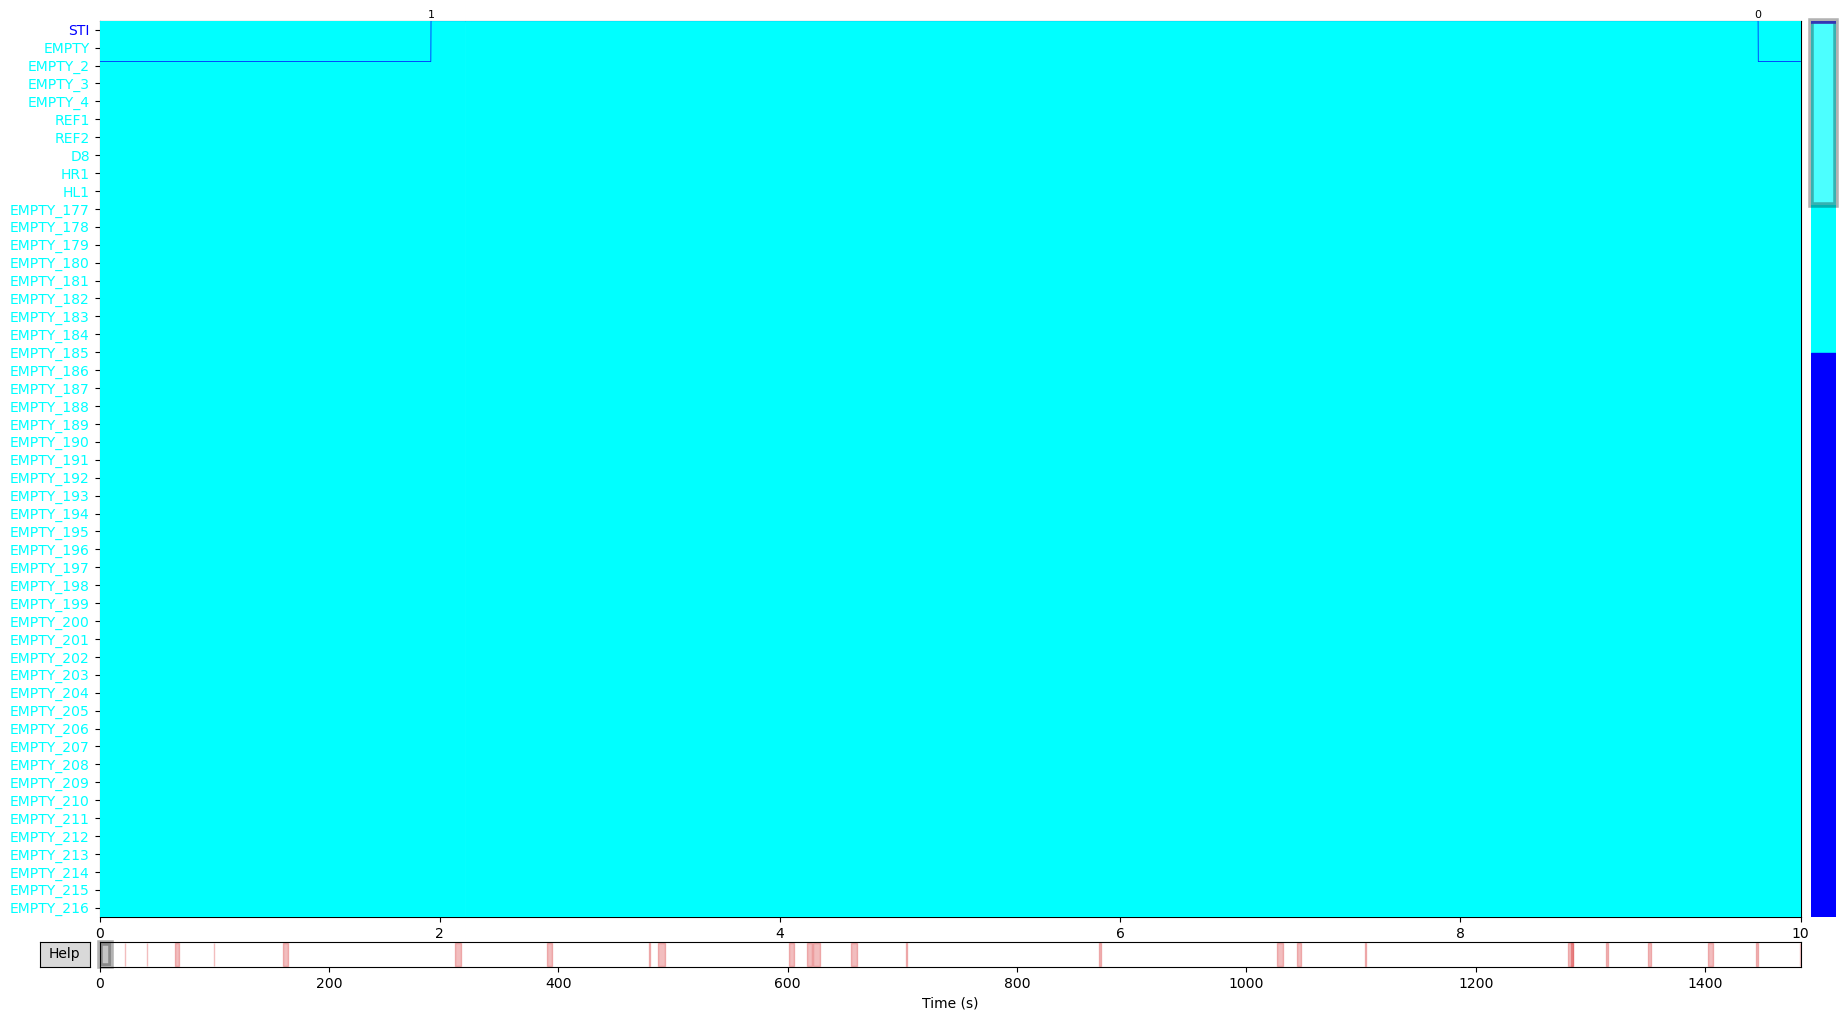

Closing raw-browser...
Channels marked as bad:
['C3_234', 'C4_239', 'CZ', 'D8', 'EKG1', 'EKG2', 'EMPTY', 'EMPTY_177', 'EMPTY_178', 'EMPTY_179', 'EMPTY_180', 'EMPTY_181', 'EMPTY_182', 'EMPTY_183', 'EMPTY_184', 'EMPTY_185', 'EMPTY_186', 'EMPTY_187', 'EMPTY_188', 'EMPTY_189', 'EMPTY_190', 'EMPTY_191', 'EMPTY_192', 'EMPTY_193', 'EMPTY_194', 'EMPTY_195', 'EMPTY_196', 'EMPTY_197', 'EMPTY_198', 'EMPTY_199', 'EMPTY_2', 'EMPTY_200', 'EMPTY_201', 'EMPTY_202', 'EMPTY_203', 'EMPTY_204', 'EMPTY_205', 'EMPTY_206', 'EMPTY_207', 'EMPTY_208', 'EMPTY_209', 'EMPTY_210', 'EMPTY_211', 'EMPTY_212', 'EMPTY_213', 'EMPTY_214', 'EMPTY_215', 'EMPTY_216', 'EMPTY_217', 'EMPTY_218', 'EMPTY_219', 'EMPTY_220', 'EMPTY_221', 'EMPTY_222', 'EMPTY_223', 'EMPTY_224', 'EMPTY_225', 'EMPTY_226', 'EMPTY_227', 'EMPTY_228', 'EMPTY_229', 'EMPTY_230', 'EMPTY_231', 'EMPTY_3', 'EMPTY_4', 'F10', 'F3_233', 'F4_238', 'F7_242', 'F8_245', 'F9', 'FP1', 'FP2', 'FPZ', 'FZ', 'HL1', 'HR1', 'O1', 'O2', 'OZ', 'P3', 'P4', 'P7', 'P8', 'PZ', 'REF1

In [6]:
# Visualize it #

bp_raw_fif.plot(events=events, color='b', bad_color = 'cyan', n_channels = 50, clipping = None, event_color = 'r')

## Epoching the data 

In [13]:
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.


/tmp/ipykernel_17895/743790177.py:1: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")


482 events found
Event IDs: [0 1 2]


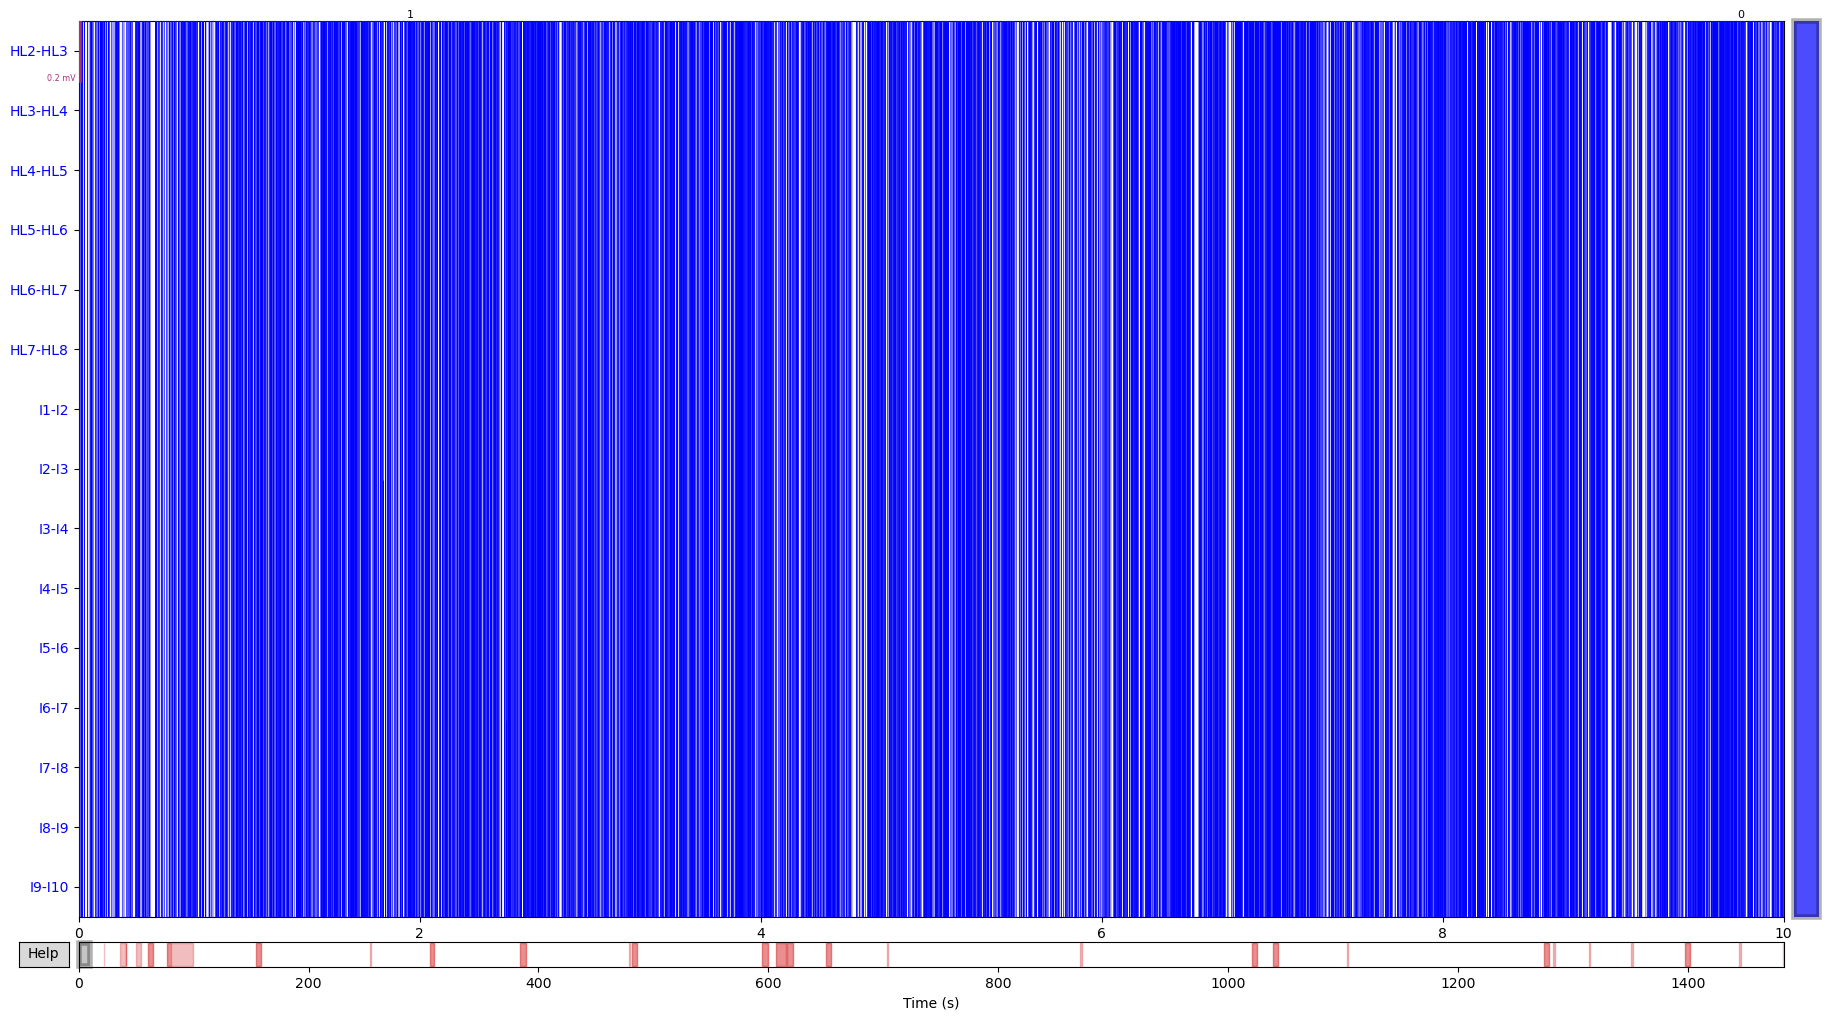

In [12]:

bp_raw_fif.pick_channels(['HL2-HL3', 'HL3-HL4', 'HL4-HL5', 'HL5-HL6', 'HL6-HL7', 'HL7-HL8', 'I1-I2', 'I2-I3', 'I3-I4', 'I4-I5', 'I5-I6', 'I6-I7', 'I7-I8', 'I8-I9', 'I9-I10']
)
bp_raw_fif.plot(events=events, color='b', bad_color = 'cyan', n_channels = 50, clipping = None, event_color = 'r')

In [6]:
## Epoching the raw data ##

# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")
events = mne.find_events(bp_filtered_fif, output='step', consecutive = True, stim_channel='STI')
# fix paused trial miscounts #
events = np.array([x for x in events if x[1] == 0])

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]

# # epoch the data
epoched_data = mne.Epochs(bp_filtered_fif, events, 
                          event_id = 1, tmin = -4, tmax = 12, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.


/tmp/ipykernel_281178/1627390569.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")


489 events found
Event IDs: [0 1 2]
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 238 events and 32001 original time points ...


/tmp/ipykernel_281178/1627390569.py:20: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


1 bad epochs dropped
Loading data for 1 events and 32001 original time points ...
Splitting into 3 parts
Loading data for 79 events and 32001 original time points ...
Loading data for 79 events and 32001 original time points ...
Loading data for 79 events and 32001 original time points ...


Loading data for 1 events and 32001 original time points ...


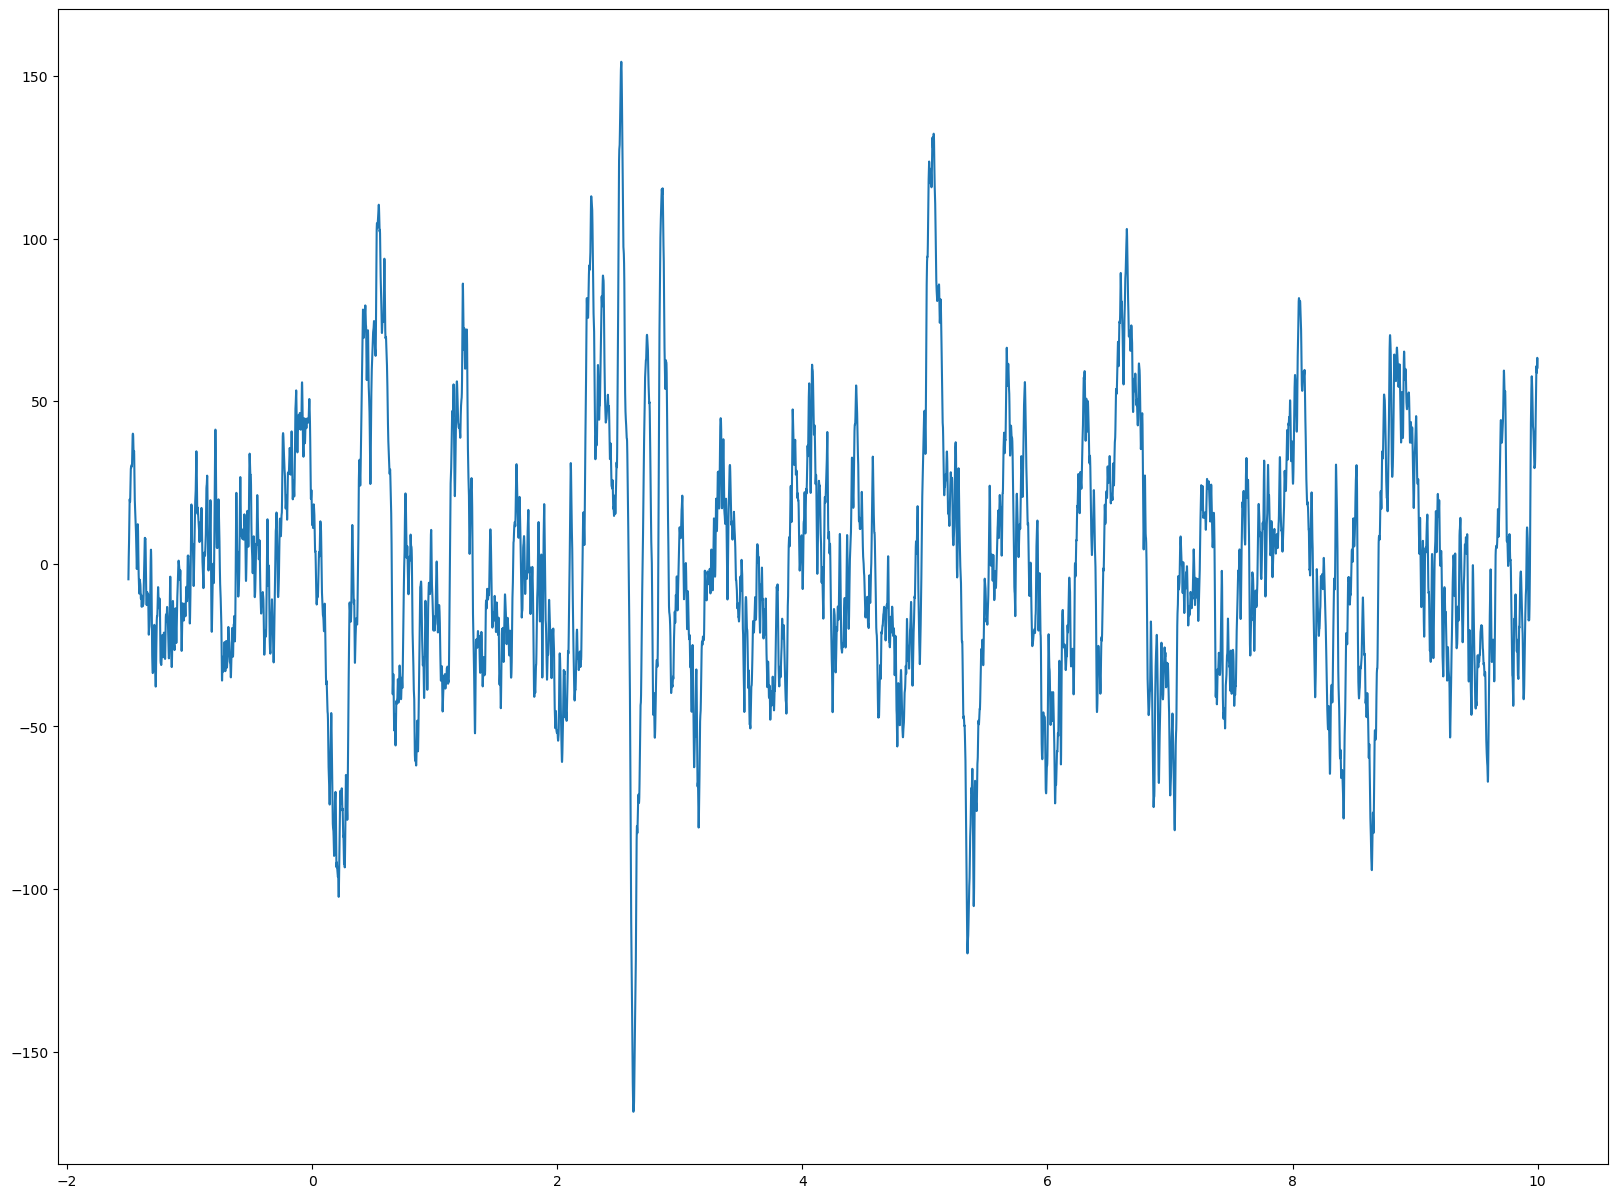

In [ ]:
plt.subplots(1, figsize=(20, 15))

ch_index = epoched_data.ch_names.index('I1-I2')

tmp = epoched_data[67].load_data().pick(['I1-I2'])

plt.plot(tmp.times[5000:28000], tmp._data[0, 0, 5000:28000])


## Trial End

In [8]:
## Epoching the raw data ##

# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")
events = mne.find_events(bp_filtered_fif, output='step', consecutive = True, stim_channel='STI')
# fix paused trial miscounts #
events = np.array([x for x in events if x[1] == 1 and x[2] == 0])
events = np.delete(events, [5, 6, 37], 0)
    
# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_filtered_fif, events, 
                          event_id = 0, tmin = -5, tmax = 5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_end-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.


/tmp/ipykernel_281178/1951367288.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")


489 events found
Event IDs: [0 1 2]
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 1 events and 20001 original time points ...
Splitting into 2 parts
Loading data for 119 events and 20001 original time points ...


/tmp/ipykernel_281178/1951367288.py:19: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_end-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_end-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


Loading data for 119 events and 20001 original time points ...


## Last Away

In [9]:
## Load Behavioral Data ##
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")
last_away_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,0,13,17700,0,1
1,2,3,42400,0,1
2,3,12,58900,0,1
3,6,6,124400,0,1
4,7,14,134100,0,1
...,...,...,...,...,...
196,233,18,2866700,0,1
197,234,4,2878900,0,1
198,235,8,2890300,0,1
199,236,7,2899500,0,1


In [10]:
# create events
last_away_events = last_away_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [11]:
# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")

# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]


# epoch the data
last_away_epochs = mne.Epochs(bp_filtered_fif, last_away_events, 
                          event_id = 1, tmin = -5, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
last_away_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_last_away_events.fif", overwrite = True, split_size = '1.9GB')


Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.
Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 20001 original time points ...


/tmp/ipykernel_281178/4116805374.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")
/tmp/ipykernel_281178/4116805374.py:14: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_last_away_events.fif", overwrite = True, split_size = '1.9GB')


Splitting into 2 parts
Loading data for 101 events and 20001 original time points ...
Loading data for 100 events and 20001 original time points ...


## First Dot

In [12]:
## Load Behavioral Data ##
first_dot_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_first_dot_events.csv")
first_dot_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,0,13,6300,0,1
1,1,11,24400,0,1
2,2,3,37000,0,1
3,3,12,52000,0,1
4,4,4,68800,0,1
...,...,...,...,...,...
221,233,18,2864200,0,1
222,234,4,2877000,0,1
223,235,8,2888700,0,1
224,236,7,2897900,0,1


In [13]:
# create events
first_dot_data = first_dot_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [14]:
# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")

# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]


# epoch the data
first_dot_epochs = mne.Epochs(bp_filtered_fif, first_dot_data, 
                          event_id = 1, tmin = -3, tmax =6, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
first_dot_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_first_dot_events.fif", overwrite = True, split_size = '1.9GB')


Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 18001 original time points ...
Splitting into 2 parts
Loading data for 113 events and 18001 original time points ...


/tmp/ipykernel_281178/4126832509.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")
/tmp/ipykernel_281178/4126832509.py:14: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_first_dot_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  first_dot_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_first_dot_events.fif", overwrite = True, split_size = '1.9GB')


Loading data for 113 events and 18001 original time points ...


## First Move

In [15]:
## Load Behavioral Data ##
first_move_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_first_move_events.csv")
first_move_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,0,13,5500,0,1
1,1,11,24100,0,1
2,2,3,36200,0,1
3,3,12,51100,0,1
4,4,4,68500,0,1
...,...,...,...,...,...
233,233,18,2863400,0,1
234,234,4,2876400,0,1
235,235,8,2888200,0,1
236,236,7,2897200,0,1


In [16]:
# create events
first_move_data = first_move_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [17]:
# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")

# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]


# epoch the data
first_move_epochs = mne.Epochs(bp_filtered_fif, first_move_data, 
                          event_id = 1, tmin = -2, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
first_move_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_first_move_events.fif", overwrite = True, split_size = '1.9GB')


Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 14001 original time points ...
Splitting into 2 parts
Loading data for 119 events and 14001 original time points ...


/tmp/ipykernel_281178/143837966.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")
/tmp/ipykernel_281178/143837966.py:14: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_first_move_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  first_move_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_first_move_events.fif", overwrite = True, split_size = '1.9GB')


Loading data for 119 events and 14001 original time points ...


## Ghost Attack

In [3]:
## Load Behavioral Data ##
ghost_attack_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_attack_events.csv")
ghost_attack_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,1,11,27200,0,1
1,3,12,58800,0,1
2,4,4,70600,0,1
3,5,15,98500,0,1
4,6,6,124200,0,1
5,9,7,156900,0,1
6,16,16,289800,0,1
7,36,6,527500,0,1
8,38,3,545900,0,1
9,39,10,558300,0,1


In [4]:
# create events
ghost_attack_data = ghost_attack_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [5]:
# load data 
bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")

# only epoch good channels
channels_of_interest =  [x for x in bp_filtered_fif.info['ch_names'] if x not in bp_filtered_fif.info['bads']]


# epoch the data
ghost_attack_epochs = mne.Epochs(bp_filtered_fif, ghost_attack_data, 
                          event_id = 1, tmin = -4, tmax =6, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
ghost_attack_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_ghost_attack_events.fif", overwrite = True, split_size = '1.9GB')


Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif...
    Range : 0 ... 2207999 =      0.000 ...  1103.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data-1.fif...
    Range : 2208000 ... 2966399 =   1104.000 ...  1483.199 secs
Ready.
Not setting metadata
42 matching events found


/tmp/ipykernel_65963/2681655913.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filtered_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif")


No baseline correction applied
0 projection items activated
Loading data for 1 events and 20001 original time points ...


/tmp/ipykernel_65963/2681655913.py:14: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_filtered_clean_ghost_attack_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ghost_attack_epochs.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_ghost_attack_events.fif", overwrite = True, split_size = '1.9GB')


Loading data for 42 events and 20001 original time points ...
